In [29]:
import pandas as pd 
import tensorflow as tf
import tensorflow_addons as tfa 
import os
from glob import glob 
import cv2
import random
from tensorflow import keras
import numpy as np

In [14]:
base_models_path = 'C:/Users/user/Desktop/models/child_skin_classification'
PATH = 'C:/Users/user/Desktop/datasets/Child Skin Disease'
# PATH = '../../datasets/Child Skin Disease'
dataset = os.path.join(PATH, 'Total_Dataset')
N_RES = 256

In [3]:
df = pd.read_csv(os.path.join(base_models_path, '20220624-110729_efficientb4_effection_history.csv'))
df 

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,0.312188,0.419258,0.350435,0.499572
1,1,0.177123,0.566368,0.320883,0.539370
2,2,0.128711,0.629766,0.290868,0.578216
3,3,0.098536,0.675723,0.282279,0.600590
4,4,0.083997,0.701123,0.286510,0.597544
5,5,0.077370,0.715451,0.276807,0.616110
6,6,0.068426,0.738728,0.266625,0.626107
7,7,0.065641,0.746724,0.282816,0.619632
8,8,0.061107,0.756497,0.267933,0.637723
9,9,0.057339,0.768665,0.275814,0.633057


In [9]:
# PATH = 'C:/Users/user/Desktop/Child Skin Disease'

# Train & test set
min_num = 100
max_num = 3000 
base_num = 1000 # baseline of data augmentation

train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files: 
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if len(imgs) > min_num and len(imgs) <= max_num: 
            
            if f in train_dict:
                train_dict[f] = train_dict[f] + len(imgs)
            else:
                train_dict[f] = len(imgs)
            
for i in range(7, 10): 
    files = [val for val in list(train_dict.keys())]
    
    for f in files:
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if f in test_dict:
            test_dict[f] = test_dict[f] + len(imgs) 
        else:
            test_dict[f] = len(imgs) 

N_CLASSES = len(train_dict)

In [10]:
N_CLASSES

78

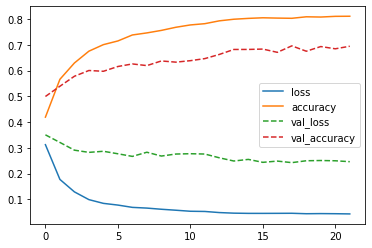

In [5]:
import matplotlib.pyplot as plt 

plt.plot(df['loss'], label='loss')
plt.plot(df['accuracy'], label='accuracy')
plt.plot(df['val_loss'], '--', label='val_loss')
plt.plot(df['val_accuracy'], '--', label='val_accuracy')
plt.legend() 
plt.show()

In [30]:
label_to_index = {}
for idx, key in zip(range(len(train_dict)), train_dict.keys()):
    label_to_index[key] = idx

In [18]:
def test_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_RES, N_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        
        # lbl = tf.keras.utils.to_categorical(label_to_index[f.split('\\')[1].split('/')[2]], len(train_dict))
        idx = f.split('\\')[2]
        
        # key = 0 
        # if idx in effection:
        #     key = 1 
            
        lbl = tf.keras.utils.to_categorical(label_to_index[key], N_CLASSES)

        yield (img, lbl)    

In [19]:
imgs = [] 
for i in range(7, 9):
    # for key in train_dict.keys():
    img = glob(dataset + f'/H{str(i)}/*/*.jpg')
    imgs.extend(img) 

In [32]:
N_BEF_RES = 256

# def test_skin_data(files):

test_images = [] 
test_labels = [] 

for f in imgs:

    # f = file.decode('utf-8')
    
    img = cv2.imread(f, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    # print(f)
    idx = f.split('\\')[-2]
    # print(idx) 
    
    # key = 0 
    # if idx in effection:
    #     key = 1 
         
    # lbl = tf.keras.utils.to_categorical(key, 2)
    lbl = tf.keras.utils.to_categorical(label_to_index[key], N_CLASSES)
    
    test_images.append(img)
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_BEF_RES, N_BEF_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_CLASSES])

In [27]:
model = keras.models.load_model(os.path.join(base_models_path, '20220624-110646_efficientb4_effection.h5'), custom_objects={'focal_loss_fixed' : tfa.losses.SigmoidFocalCrossEntropy()})

In [33]:
test_preds = model.predict(test_images)

In [36]:
test_preds

array([[1.3506900e-05, 1.1716162e-06, 4.5620367e-05, ..., 3.9077085e-04,
        2.4111765e-05, 7.2151804e-01],
       [8.3295623e-07, 4.7514670e-05, 2.0689045e-05, ..., 1.0653094e-04,
        5.3129452e-06, 5.3643197e-01],
       [3.3114361e-06, 2.2497770e-04, 4.2861320e-05, ..., 9.7511038e-05,
        2.2911487e-05, 2.8393385e-01],
       ...,
       [1.5185856e-04, 1.1013608e-04, 4.0728286e-05, ..., 6.6110743e-03,
        9.7734971e-07, 4.7162724e-01],
       [1.7390137e-04, 2.7538519e-05, 4.0452411e-05, ..., 2.0855583e-02,
        3.6823681e-06, 1.9993262e-02],
       [3.8974002e-05, 4.2080997e-06, 2.3866298e-06, ..., 2.1034654e-04,
        2.3565199e-06, 8.1364483e-01]], dtype=float32)

In [37]:
import sklearn 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
import seaborn as sns

# sklearn.metrics.f1_score(test_labels[:100], y_pred, average='binary')
cm = sklearn.metrics.confusion_matrix(test_labels.argmax(axis=1), test_preds.argmax(axis=1))
# cm 
# f1_score = sklearn.metrics.f1_score(test_labels.argmax(axis=1), test_preds.argmax(axis=1))
# precision = sklearn.metrics.precision_score(test_labels.argmax(axis=1), test_preds.argmax(axis=1))
# recall = sklearn.metrics.recall_score(test_labels.argmax(axis=1), test_preds.argmax(axis=1))


In [56]:
model.evaluate(test_images, test_labels)

6/6 [==============================] - 3s 134ms/step - loss: 0.7476 - accuracy: 0.4699


[0.7475525140762329, 0.46987950801849365]

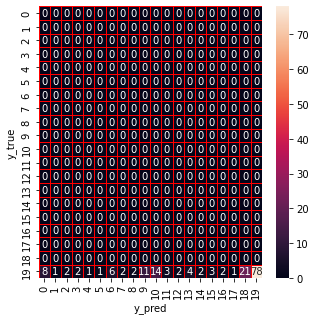

In [38]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor='red', fmt='.0f', ax=ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')

plt.show()

In [48]:
f1_score = sklearn.metrics.f1_score(test_labels.argmax(axis=1), test_preds.argmax(axis=1), average='micro')
f1_score


0.46987951807228917

In [51]:

precision = sklearn.metrics.precision_score(test_labels.argmax(axis=1), test_preds.argmax(axis=1), average='micro')
recall = sklearn.metrics.recall_score(test_labels.argmax(axis=1), test_preds.argmax(axis=1), average='micro')

precision, recall

(0.46987951807228917, 0.46987951807228917)